# https://www.kaggle.com/code/gunesevitan/survival-analysis/notebook

In [17]:
# !pip install lifelines

In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

# Intro: Survival Analysis
Survival analysis è una branca della statistica che si occupa di analizzare la durata nel tempo di un fenomeno fino al verificarsi di un evento, come morte biologica o fallimento meccanico. Generalmente questo topic è denominato **Reliability Analysis** nel campo dell'ingenieria, **Duration Analysis** o **Duration Modelling** in economia, ed **Event History Analysis** in sociologia.

In [19]:
df_metabric = pd.read_csv('Breast Cancer METABRIC.csv')

print(f'METABRIC Dataset Shape: {df_metabric.shape}')
print(f'METABRIC Dataset Memory Usage: {df_metabric.memory_usage().sum() / 1024 ** 2:.2f} MB')

METABRIC Dataset Shape: (2509, 34)
METABRIC Dataset Memory Usage: 0.65 MB


# Cap 1: Breast Cancer (METABRIC) Dataset EDA
In questo dataset sono presenti 2509 unici record di pazienti affetti da cancro al seno. 
L'età varia da 21.9 a 96.3 anni, e mediamente l'evento si verifica intorno ai 60.4 anni. Nello speicifico, i pazienti posso essere sottoposti a due tipi di interventi: Mastectomy (rimozione dei seni) o Breas-conserving surgery (rimozione solo della massa tumorale).

Inoltre, sono presenti 3 casi di sarcoma, ovvero una forma molto rara di cancro al seno, la quale avviene per meno dell'1% dei casi. Il tipo di cancro più comune è detto carcinoma (IDC), con 1865 casi presenti. Si noti che l'IDC rappresenta più dell'80% dei casi.

PS: questo database è molto valido, e replica abbastanza bene la realtà dei casi.

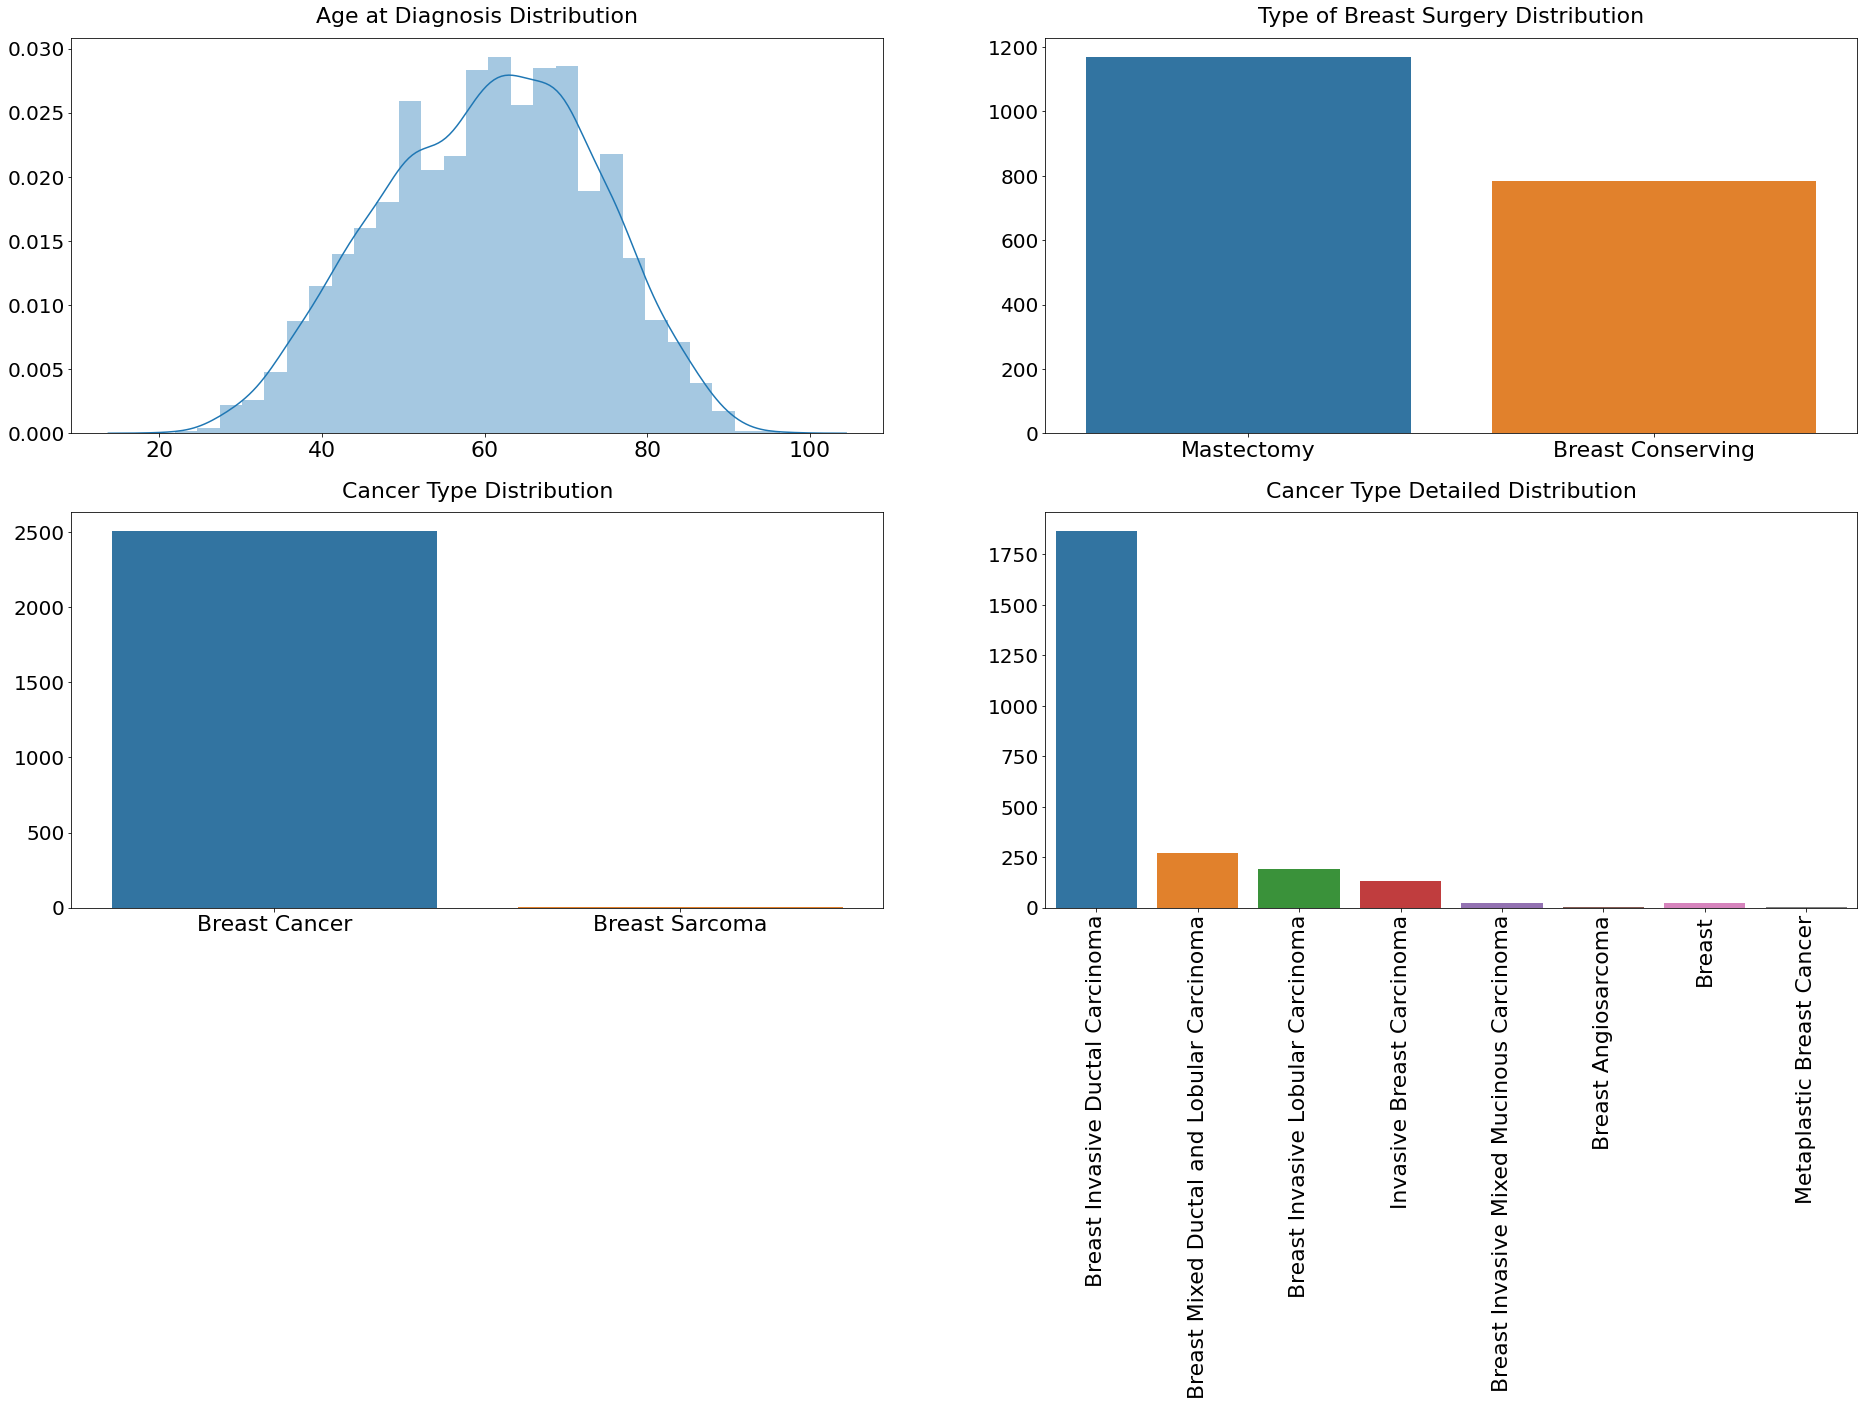

In [20]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(df_metabric['Age at Diagnosis'], ax=axes[0][0])
sns.countplot(df_metabric['Type of Breast Surgery'], ax=axes[0][1])
sns.countplot(df_metabric['Cancer Type'], ax=axes[1][0])
sns.countplot(df_metabric['Cancer Type Detailed'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22, rotation=90)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=20)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Age at Diagnosis Distribution', size=22, pad=15)
axes[0][1].set_title('Type of Breast Surgery Distribution', size=22, pad=15)
axes[1][0].set_title('Cancer Type Distribution', size=22, pad=15)
axes[1][1].set_title('Cancer Type Detailed Distribution', size=22, pad=15)

plt.show()

In questo dataset, ci sono due eventi che vengono registrati per ogni paziente:
*   Sopravvivenza (**Overall Survival Status**);
*   Relapse (**Relapse Free Status**), ovvero se il cancro si ripresenta.

La *Survival Analysis* fatta in questo script si baserà su questi due eventi e sulla loro durata.
Entrambe le durate hanno una distribuzione simile.

Si noti inoltre che per la sopravvivenza, c'è una maggioranza di casi di decessi, mentre per la possibilità che si ripresenti è più probabile che il cancro non torni una volta sconfitto!

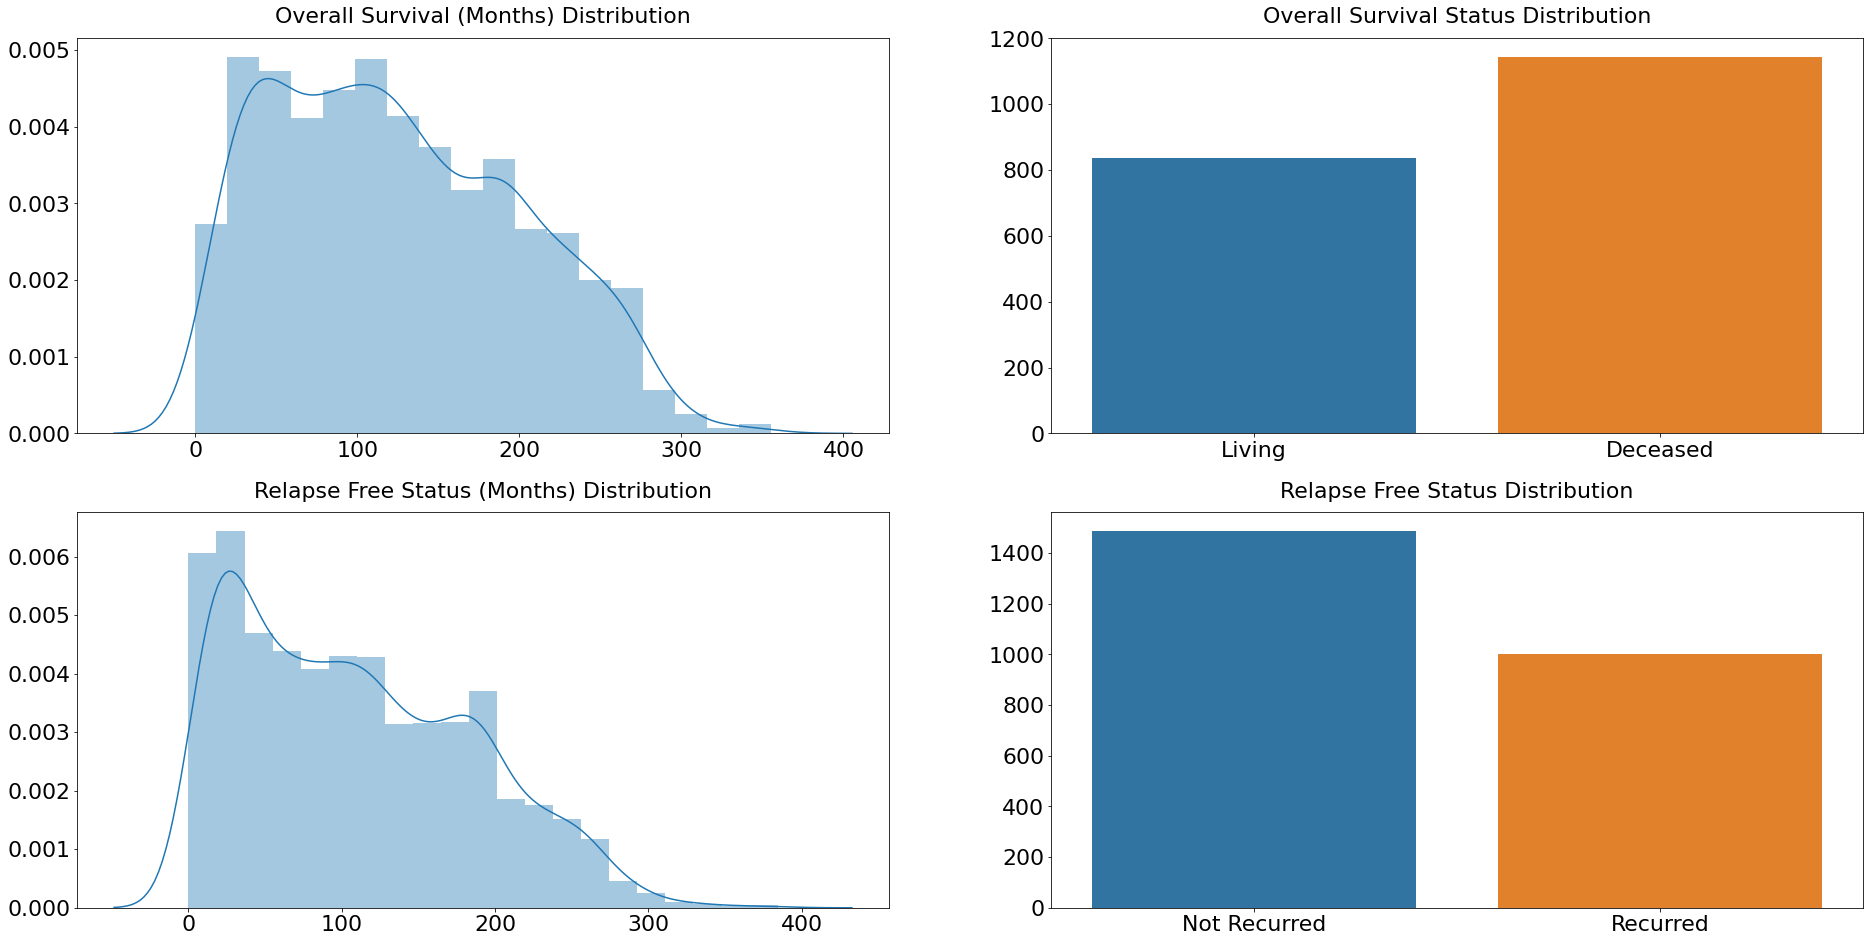

In [21]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(df_metabric['Overall Survival (Months)'], ax=axes[0][0])
sns.countplot(df_metabric['Overall Survival Status'], ax=axes[0][1])
sns.distplot(df_metabric['Relapse Free Status (Months)'], ax=axes[1][0])
sns.countplot(df_metabric['Relapse Free Status'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=22)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Overall Survival (Months) Distribution', size=22, pad=15)
axes[0][1].set_title('Overall Survival Status Distribution', size=22, pad=15)
axes[1][0].set_title('Relapse Free Status (Months) Distribution', size=22, pad=15)
axes[1][1].set_title('Relapse Free Status Distribution', size=22, pad=15)

plt.show()

Nei dati disponibili per questo dataset sono presenti diversi indicatori biologici per ogni paziente, come:

* Consistenza del tessuto tumorale;
* Chemioterapia svolta (dummy);
* Terapie ormonali (dummy);
* Radio terapia (dummy);
* ER, PR, HER2 status;
* Subtype, dimensione, stage, etc... (del tumore diagnosticato)

Prima di procedere alla Survival Analysis, dovremmo prima pulire e sistemare queste variabili.

In [22]:
df_metabric.head(3)

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease


# Cap 2: Pre-processing e pulizia dati

Iniziamo controllando i missing value nelle nostre 29 colonne.

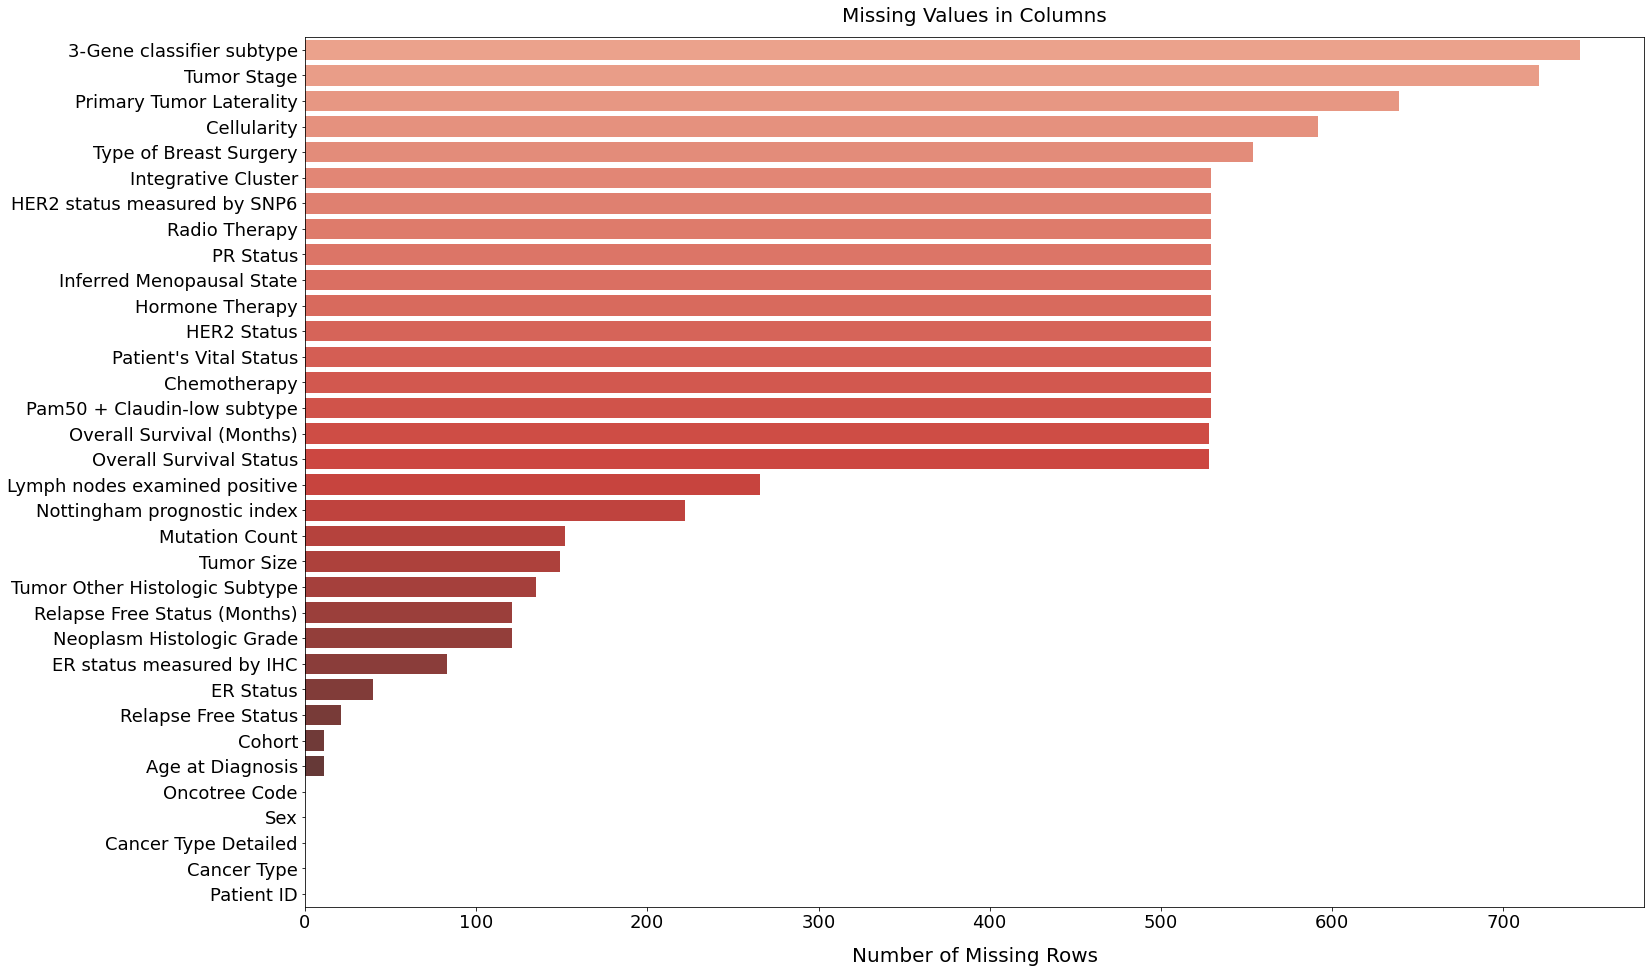

In [23]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=df_metabric.isnull().sum().sort_values(ascending=False).values,
            y=df_metabric.isnull().sum().sort_values(ascending=False).index,
            palette='Reds_d')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

Solo 5 colonne non hanno valori mancanti. Per le altre colonne:
* Per le variabili che registrano eventi, andremo ad imputare il valore più comune;
* Per le variabili di durata andremo ad imputare la durata più presente relativamente al *Cancer Type Detailed*;
* Per ER,PR e HER2 Status imputiamo il valore più comune;
* Per Chemotherapy, Hormone therapy e Radio therapy imputiamo il valore più presente in relazione al *Cancer Type Detailed*;
* Infine, per *Patient's Vital Status* siamo costretti a dropparla, in quanto non abbiamo alcuna informazione a riguardo che possa aiutarci;

NB: in alcuni casi, il processo di imputazione prevedere diversi passaggi.

In [24]:
# Event and duration columns
df_metabric['Relapse Free Status'] = df_metabric.groupby(['Cancer Type Detailed'])['Relapse Free Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Relapse Free Status (Months)'] = df_metabric.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].apply(lambda x: x.fillna(x.mean()))
df_metabric['Overall Survival Status'] = df_metabric.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Overall Survival (Months)'] = df_metabric.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].apply(lambda x: x.fillna(x.mean()))

# ER, PR, HER2 status columns
df_metabric['ER status measured by IHC'] = df_metabric['ER status measured by IHC'].fillna(mode(df_metabric['ER status measured by IHC'])[0][0])
df_metabric['ER Status'] = df_metabric.groupby(['ER status measured by IHC'])['ER Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['HER2 status measured by SNP6'] = df_metabric['HER2 status measured by SNP6'].fillna(mode(df_metabric['HER2 status measured by SNP6'])[0][0])
df_metabric['HER2 Status'] = df_metabric.groupby(['HER2 status measured by SNP6'])['HER2 Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['PR Status'] = df_metabric.groupby(['Cancer Type Detailed'])['PR Status'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Chemotherapy, Hormone Therapy, Radio Therapy columns
df_metabric['Chemotherapy'] = df_metabric.groupby(['Cancer Type Detailed'])['Chemotherapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Hormone Therapy'] = df_metabric.groupby(['Cancer Type Detailed'])['Hormone Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Radio Therapy'] = df_metabric.groupby(['Cancer Type Detailed'])['Radio Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Other columns
df_metabric['Age at Diagnosis'] = df_metabric.groupby(['Cancer Type Detailed'])['Age at Diagnosis'].apply(lambda x: x.fillna(x.mean()))
df_metabric['Cohort'] = df_metabric.groupby(['Cancer Type Detailed'])['Cohort'].apply(lambda x: x.fillna(x.median()))
df_metabric['Cellularity'] = df_metabric.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Tumor Stage'] = df_metabric.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Stage'] = df_metabric.groupby(['Cancer Type Detailed'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Size'] = df_metabric.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Size'] = df_metabric.groupby(['Cancer Type Detailed'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
df_metabric['Tumor Size'] = df_metabric['Tumor Size'].fillna(mode(df_metabric['Tumor Size'])[0][0])
df_metabric['Neoplasm Histologic Grade'] = df_metabric.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Neoplasm Histologic Grade'] = df_metabric['Neoplasm Histologic Grade'].fillna(mode(df_metabric['Neoplasm Histologic Grade'])[0][0])
df_metabric['Primary Tumor Laterality'] = df_metabric.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Tumor Other Histologic Subtype'] = df_metabric.groupby(['Cancer Type Detailed'])['Tumor Other Histologic Subtype'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Tumor Other Histologic Subtype'] = df_metabric['Tumor Other Histologic Subtype'].fillna('Ductal/NST')
df_metabric['Mutation Count'] = df_metabric.groupby(['Cancer Type Detailed'])['Mutation Count'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Mutation Count'] = df_metabric['Mutation Count'].fillna(mode(df_metabric['Mutation Count'])[0][0])
df_metabric['Nottingham prognostic index'] = df_metabric.groupby(['Tumor Size'])['Nottingham prognostic index'].apply(lambda x: x.fillna(x.median()))
df_metabric['Nottingham prognostic index'] = df_metabric['Nottingham prognostic index'].fillna(df_metabric['Nottingham prognostic index'].median())
df_metabric['Lymph nodes examined positive'] = df_metabric.groupby(['Cancer Type Detailed'])['Lymph nodes examined positive'].apply(lambda x: x.fillna(x.mode()))
df_metabric['Lymph nodes examined positive'] = df_metabric['Lymph nodes examined positive'].fillna(mode(df_metabric['Lymph nodes examined positive'])[0][0])
df_metabric['Inferred Menopausal State'] = df_metabric['Inferred Menopausal State'].fillna(mode(df_metabric['Inferred Menopausal State'])[0][0])
df_metabric['Pam50 + Claudin-low subtype'] = df_metabric.groupby(['Cancer Type Detailed'])['Pam50 + Claudin-low subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Integrative Cluster'] = df_metabric.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Type of Breast Surgery'] = df_metabric.groupby(['Cancer Type Detailed'])['Type of Breast Surgery'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['Primary Tumor Laterality'] = df_metabric.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(mode(x)[0][0]))
df_metabric['3-Gene classifier subtype'] = df_metabric.groupby(['Cancer Type Detailed'])['3-Gene classifier subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))

df_metabric.drop(columns=["Patient's Vital Status"], inplace=True)

Sistemiamo i formati delle colonne, ad esempio convertiamo le variabili *object* nel formato *uint8* per un utilizzo minore di memoria.
Per i due eventi *Overall Survival Status* e *Relapse Free Status* vengono codificati manualmente in quanto *LabelEncoder* può erroneamente codificare un evento successo come 0 (e non come 1).

In [25]:
object_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
               'Chemotherapy', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
               'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
               'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality',
               'Oncotree Code', 'PR Status', 'Radio Therapy', 'Sex', '3-Gene classifier subtype']

for col in object_cols:
    df_metabric[col] = np.uint8(LabelEncoder().fit_transform(df_metabric[col]))
    
df_metabric['Overall Survival Status'] = np.uint8(df_metabric['Overall Survival Status'].map({'Living': 0, 'Deceased': 1}))
df_metabric['Relapse Free Status'] = np.uint8(df_metabric['Relapse Free Status'].map({'Not Recurred': 0, 'Recurred': 1}))

Dato che ogni colonna ora è numerica, è possibile calcolarne la correlazione. Sono presenti alcune forti correlazioni (>0.6 o <-0.6) le quali hanno perfettamente senso, dato che spesso i parametri biologici sono connessi tra loro. E' presente inoltre una perfetta correlazione positiva tra *Cellularity* e *INtegrative Cluster*, quindi basta dropparne una. Una ulteriore cosa da considerare, è la forte correlazione tra *Overall Survival Status* e *Relapse Free Status*. Rimuoviamo inoltre la variabile *Sex*, in quanto tutte le pazienti sono donne (degenere).

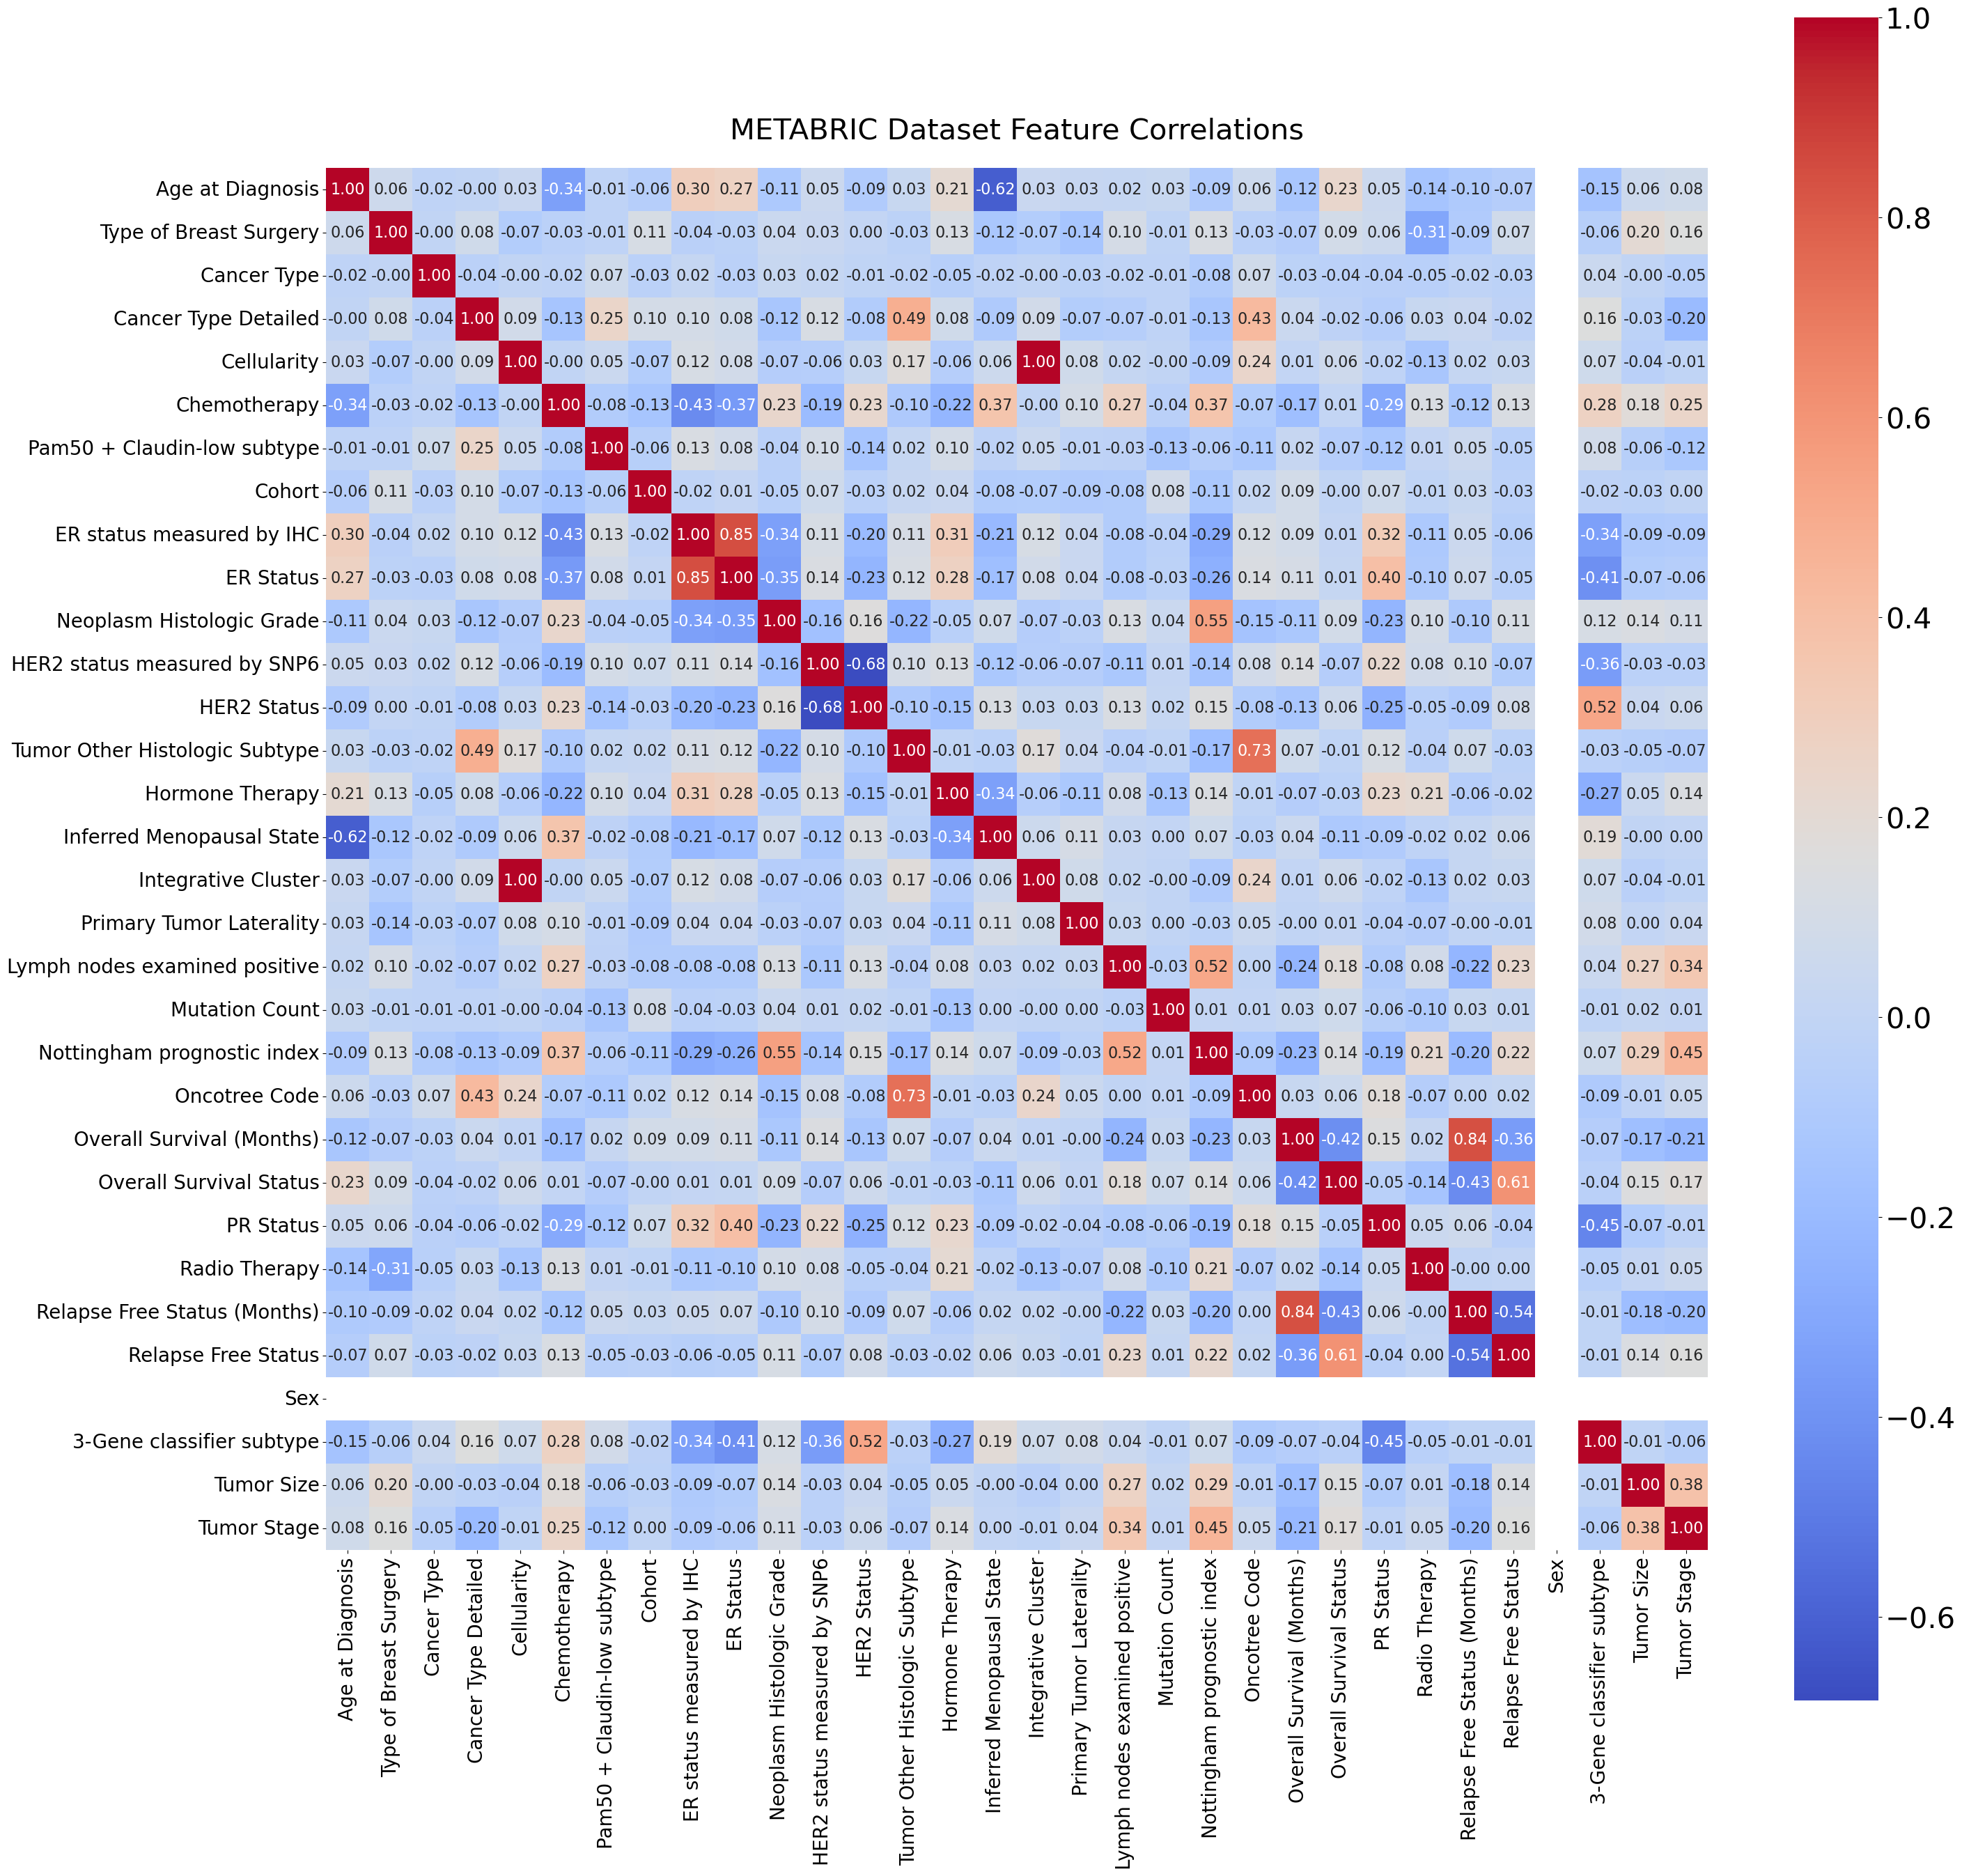

In [26]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(df_metabric.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16},  fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)
plt.title('METABRIC Dataset Feature Correlations', size=30, pad=30)

plt.show()

In [27]:
df_metabric.drop(columns=['Integrative Cluster', 'Sex'], inplace=True)

# Cap 3: Teoria
*   Sia $T$ una durata temporale (non negativa) legata ad un determinato evento in esame;
*   Sia $S(T)$ la *Survival Function* di una popolazione, definibile come $S(T) = Pr(T>t)$ ovvero **la probabilità che l'evento non si sia ancora verificato al tempo $t$, oppure, come la probabilità di sopravvivere passato il tempo $t$**;

Inoltre:
*   $T$ è la durata vitale (casuale) presa dal dataset in esame, e non può essere negativa;
*   La funzione di sopravvivenza $S(t)$ ha un output compreso tra 0 ed 1, e non è una funzione incrementale rispetto a $t$;
*   All'inizio del periodo in esame ($t=0$), nessun evento può avere avuto già luogo. Quindi, la probabilità (di sopravvivenza) $S(0)$ è pari ad 1. Mentre $S(inf)$ è pari a 0, dato che il periodo di studio è infinito, e la probabilità di sopravvivere su un tempo infinito è 0.

NB: In teoria, la funzione di sopravvivenza è una curva liscia, ma nella pratica gli eventi vengono osservati su una scala tarata del tempo (ex: giorni, settimane, mesi) generando quindi una funzione a scalini.

## 3.1 Hazard Function

La **Hazard Function $h(t)$** restituisce la probabilità che l'evento si verifichi al tempo $t$, dato che l'evento ancora non si è verificato.
Possiamo dire che $h(t)$ descrive il potenziale istantaneo, per una unità di tempo, che l'evento si verifichi. Essa viene formulata come segue:

* $LIM_{\delta t->0}  Pr(t≤T≤t+δt|T>t)$

Questa quantità tende a 0 al ridursi di $\delta t$, per questo motivo si divide l'intervallo per $\delta t$.
Pertanto, possiamo definire la funzione $h(t)$ al tempo $t$ come:

*   $h(t)=LIM_{\delta t->0} \frac{Pr(t≤T≤t+δt|T>t)}{\delta t}$

Difatto, la *Hazard Function* va a modellare quali siano i periodi con più alta o più bassa probabilità del verificarsi dell'evento. In contrato con la *Survival Function*, $h(t)$ non necessata di partire da 1 e scendere successivamente a 0. Generalmente, l'*hazard rate* cambia nel tempo, e non ha un inizio o una fine prefissata.


## 3.2 Censoring
Un concetto base utile per una *Survival Analysis* è il *Censoring*.
Per le analisi di sopravvivenza vale il concetto di **censura**. 
Difatto, possiamo avere due osservazioni:
*   E' possibile misurare un evento solo al suo verificarsi;
*   L'evento non è avvenuto nel periodo di osservazione, e quindi solo il numero dei giorni in cui **non si è verificato** è noto (*censored*)

Ci sono due gruppi, ono dove il momento dell'evento è noto esattamente, e uno dove non lo è.
Nel secondo gruppo è noto solamente un certo ammontare di tempo dove l'evento di interesse non è avvenuto. Questo gruppo è detto di *censura* (*censored*). Un errore comune è lo scegliere di ignorare questo gruppo di osservazioni. Noi non sappiamo quando effettivamente l'evento si sarebbe verificato ampliando il periodo di studio, ma sapere che esso non si sia verificato per un certo periodo ci permettere di avere una ulteriore informazione per descrivere il rischio del verificarsi dell'evento stesso per una singola persona.

Si noti tuttavia, che una possibile causa di censura è il non poter osservare le persone per sempre. Ad un certo punto, il perido di studio deve finire, e non è detto che tutte le persone seguite abbiano sperimentato l'evento. Un'altra causa comune è la perdita di follow-up sulle persone seguite, e questo caso in particolare è detto *Random Ccensoring* (genericamente si verifica per cause diverse che portano alla fine della reperibilità della persona seguita).
Si noti che, non tutte le persone seguite hanno lo stesso periodo di studio, tuttavia è possibile tenerne conto durante l'analisi.

Esistono 3 tipi di *censoring*:
*   **right**
*   **left**
*   **interval**



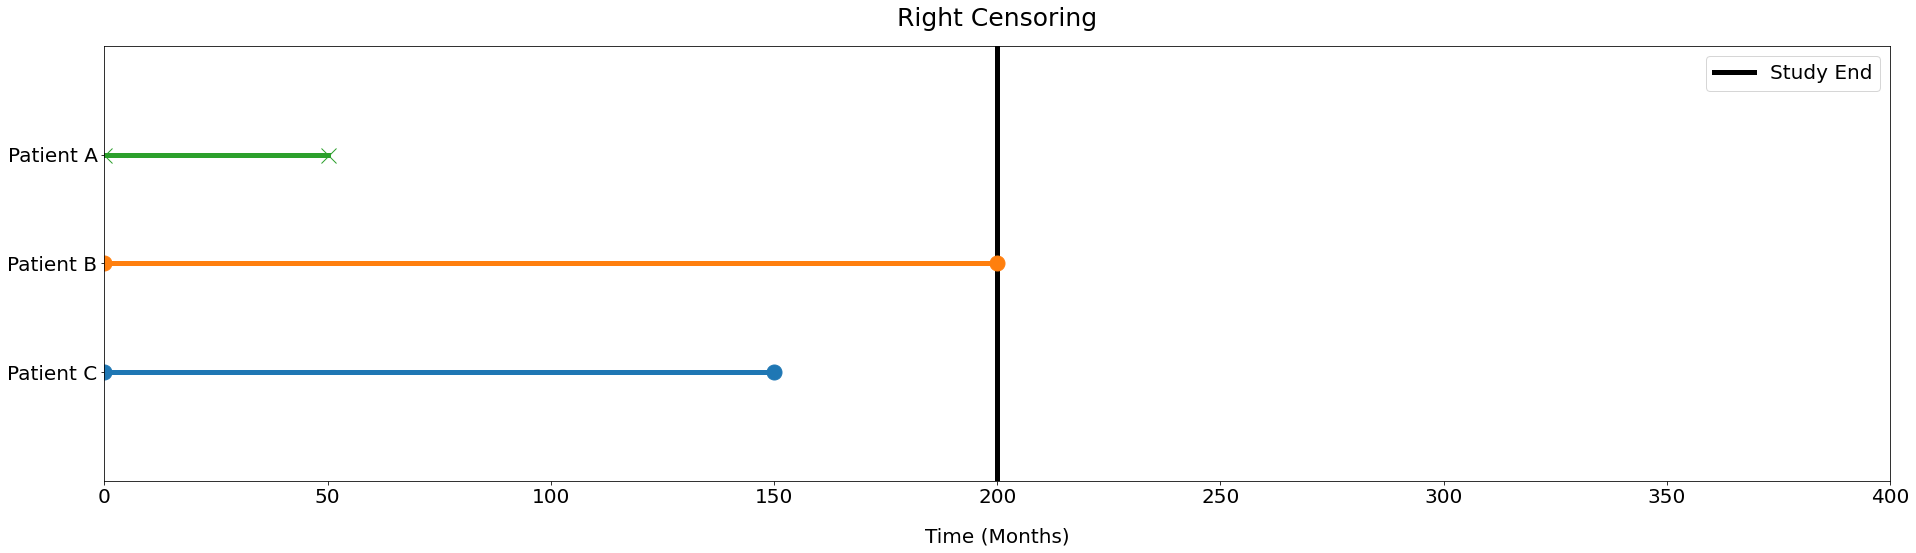

In [29]:
fig = plt.figure(figsize=(32, 8))

plt.xlim(0, 400), plt.ylim(0, 4)
plt.axvline(200, color='black', label='Study End', linewidth=5)
plt.plot([0, 150], [1, 1], marker='o', markersize=15, linewidth=5)
plt.plot([0, 200], [2, 2], marker='o', markersize=15, linewidth=5)
plt.plot([0, 50], [3, 3], marker='x', markersize=15, linewidth=5)

plt.xlabel('Time (Months)', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.yticks([1, 2, 3], ['Patient C', 'Patient B', 'Patient A'])
plt.legend(prop={'size': 20})
plt.title('Right Censoring', size=25, pad=20)

plt.show()

In [30]:
def time_dependent_roc_auc_score(y_true, y_pred, survival_times):

    """
    Calculate roc auc score at given times

    Parameters
    ----------
    y_true: array-like of shape (n_samples)
    Binary event vector
    y_pred: array-like of shape (n_samples, n_evaluation_times)
    Predicted event probabilities at given times
    survival_times: array-like of shape (n_samples)
    Continuous time vector

    Returns
    -------
    scores: dict (time: score)
    A dictionary of times and scores
    """

    time_dependent_y_true = pd.DataFrame(data=np.zeros((y_pred.shape[0], y_pred.shape[1])),
                                         index=y_true.index,
                                         columns=y_pred.columns,
                                         dtype=np.uint8)

    for i, time in enumerate(y_pred.columns):
        time_dependent_y_true.iloc[:, i] = ((y_true == 1) & (time >= survival_times)).astype(np.uint8)

    scores = {}
    for time in y_pred.columns:
        score = np.round(roc_auc_score(time_dependent_y_true[time], y_pred[time]), 6)
        scores[int(time)] = score

    return scores

In [31]:
df_train, df_test = train_test_split(df_metabric,
                                     test_size=0.2,
                                     stratify=df_metabric['Cancer Type Detailed'],
                                     shuffle=True,
                                     random_state=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
for fold, (_, val_idx) in enumerate(skf.split(df_train, df_train['Cancer Type Detailed']), 1):
    df_train.loc[val_idx, 'fold'] = fold

df_train['fold'] = df_train['fold'].astype(np.uint8)

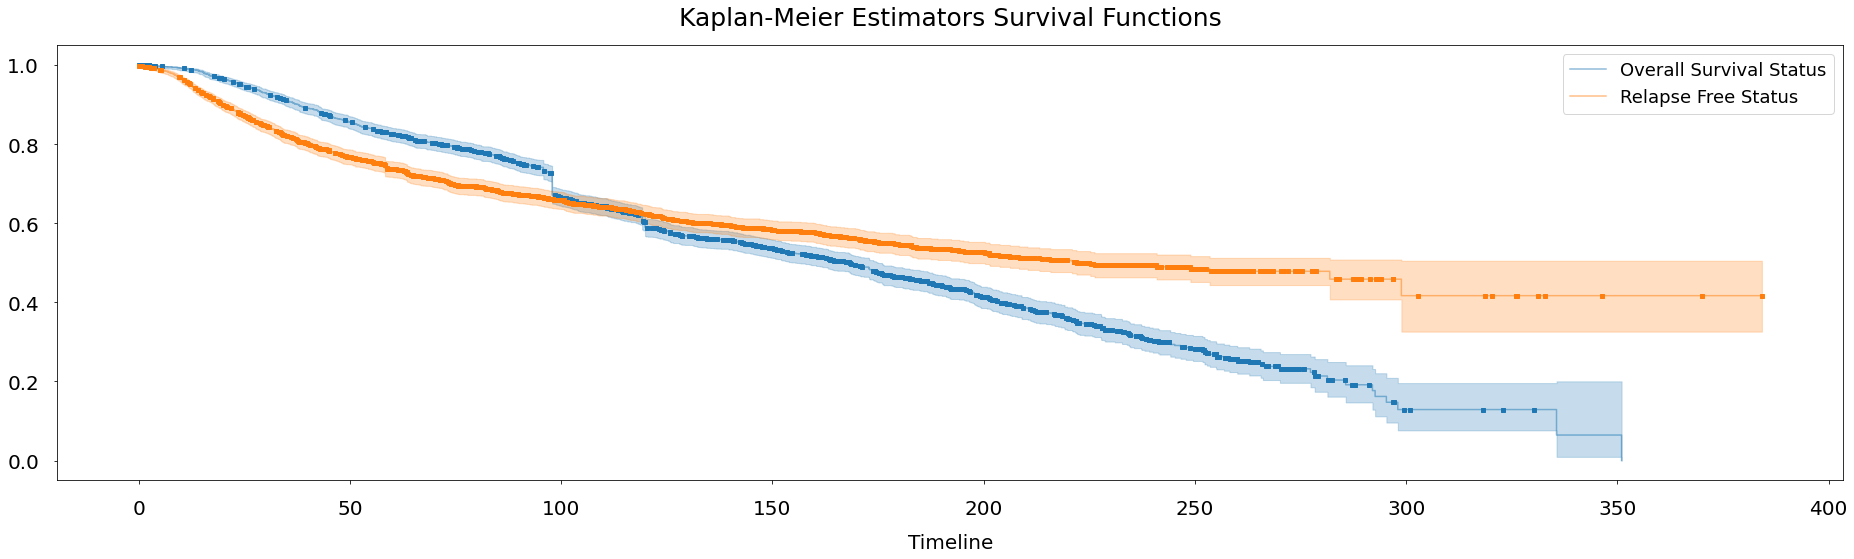

In [32]:
fig = plt.figure(figsize=(32, 8))

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
       
    T, E = df_train[time], df_train[event]
    kmf = KaplanMeierFitter()
    kmf.fit(T, E)
    kmf.plot(label=event, alpha=0.5, show_censors=True, censor_styles={'ms': 4, 'marker': 's'})
    
plt.xlabel('Timeline', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20, pad=15)
plt.tick_params(axis='y', labelsize=20, pad=15)
plt.legend(prop={'size': 18})
plt.title('Kaplan-Meier Estimators Survival Functions', size=25, pad=20)

plt.show()

In [33]:
evaluation_times = [12, 24, 36]

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
    
    df_oof_survival_function = pd.DataFrame(data=np.zeros((df_train.shape[0], len(evaluation_times))),
                                                index=df_train.index,
                                                columns=evaluation_times)
    df_test_survival_function = pd.DataFrame(data=np.zeros((df_test.shape[0], len(evaluation_times))),
                                             index=df_test.index,
                                             columns=evaluation_times)
    
    for fold in sorted(df_train['fold'].unique()):
                    
        trn_idx, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index       
        T_trn, E_trn = df_train.loc[trn_idx, time], df_train.loc[trn_idx, event]
        T_val, E_val = df_train.loc[val_idx, time], df_train.loc[val_idx, event]
        kmf = KaplanMeierFitter()
        kmf.fit(T_trn, E_trn)
        
        survival_function = kmf.predict(times=evaluation_times)        
        val_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), T_val.shape[0])),
                                             index=val_idx,
                                             columns=evaluation_times)        
        df_oof_survival_function.loc[val_idx, :] = val_survival_function.values        
        test_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), df_test.shape[0])),
                                              index=df_test.index,
                                              columns=evaluation_times)
        df_test_survival_function += (test_survival_function.values / n_splits)

        val_auc = time_dependent_roc_auc_score(df_train.loc[val_idx, event], val_survival_function, df_train.loc[val_idx, time])
        print(f'Fold {fold} ({time}) - ROC AUC Scores {val_auc}')
        
    oof_auc = time_dependent_roc_auc_score(df_train[event], df_oof_survival_function, df_train[time])
    test_auc = time_dependent_roc_auc_score(df_test[event], df_test_survival_function, df_test[time])
    print(f'{"-" * 30}\nKaplan Meier Estimate {time} OOF AUC: {oof_auc}')
    print(f'Kaplan-Meier Estimate {time} Test AUC: {test_auc}\n{"-" * 30}\n')

Fold 1 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------
Kaplan Meier Estimate Overall Survival (Months) OOF AUC: {12: 0.649796, 24: 0.524038, 36: 0.518953}
Kaplan-Meier Estimate Overall Survival (Months) Test AUC: {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------

Fold 1 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Relapse Fre